In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler ,LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

# load and explore the data

In [ ]:
# Load the dataset
df = pd.read_csv('BitcoinHeistData.csv')
print(f"Data loaded successfully.")
#check data
df.head()

Data loaded successfully.


,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


# Basic Dataset Overview

In [ ]:
 # Display basic information
print("\n===== DATASET OVERVIEW =====")
#print(f"data info :{df.info}")
print(f"Dataset shape: {df.shape}")
print(f"Features available: {df.columns.tolist()}")
print(f"Number of unique addresses: {df['address'].nunique()}")

    # Check for missing values
missing = df.isnull().sum()
print("\n===== MISSING VALUES =====")
print(missing[missing > 0])

    # Class distribution
print("\n===== CLASS DISTRIBUTION =====")
label_counts = df['label'].value_counts()
print(label_counts)

print("\n===== Ransomware Family Distribution =====")
print(label_counts / len(df) * 100)


===== DATASET OVERVIEW =====
Dataset shape: (2916697, 10)
Features available: ['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income', 'label']
Number of unique addresses: 2631095

===== MISSING VALUES =====
Series([], dtype: int64)

===== CLASS DISTRIBUTION =====
label
white                          2875284
paduaCryptoWall                  12390
montrealCryptoLocker              9315
princetonCerber                   9223
princetonLocky                    6625
montrealCryptXXX                  2419
montrealNoobCrypt                  483
montrealDMALockerv3                354
montrealDMALocker                  251
montrealSamSam                      62
montrealCryptoTorLocker2015         55
montrealGlobeImposter               55
montrealGlobev3                     34
montrealGlobe                       32
montrealWannaCry                    28
montrealRazy                        13
montrealAPT                         11
paduaKeRanger                    

#  Analyzing the Target Variable (Ransomware Labels)

 # Feature Distributions between ransomware families.

In [ ]:
import pandas as pd

# Calculate correlation matrix (only numerical features)
correlation_matrix = df.corr(numeric_only=True)

# Unstack the matrix to get pairwise combinations, and drop self-correlations
correlations = correlation_matrix.unstack().reset_index()
correlations.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Remove duplicate pairs (A-B and B-A) and self-pairs
correlations = correlations[correlations['Feature_1'] != correlations['Feature_2']]
correlations['Pair'] = correlations.apply(lambda row: tuple(sorted([row['Feature_1'], row['Feature_2']])), axis=1)
correlations = correlations.drop_duplicates(subset='Pair').drop(columns='Pair')

# Find highest positive and highest negative correlation
highest_positive = correlations.sort_values(by='Correlation', ascending=False).iloc[0]
highest_negative = correlations.sort_values(by='Correlation').iloc[0]

print("Highest Positive Correlation:")
print(highest_positive)

print("\n Highest Negative Correlation:")
print(highest_negative)


Highest Positive Correlation:
Feature_1        length
Feature_2         count
Correlation    0.703467
Name: 20, dtype: object

 Highest Negative Correlation:
Feature_1          year
Feature_2           day
Correlation   -0.040307
Name: 1, dtype: object


# analysis of variance ANOVA & F-test
 - Higher F-test values indicate the feature is better at separating different ransomware classes

 - P_Value shows the statistical significance. Values close to zero , indicate that the differences between ransomware groups for each feature are highly unlikely to occur by chance


=== Feature Importance (ANOVA F-test) ===
     Feature     F_Score        P_Value
6       year  539.239923   0.000000e+00
7        day  232.069147   0.000000e+00
1     weight   69.873416   0.000000e+00
2      count   50.522329  1.407696e-280
3     looped   36.218566  1.606041e-195
0     length   28.871513  3.855576e-152
4  neighbors    1.856996   3.840378e-03
5     income    1.699867   1.184025e-02


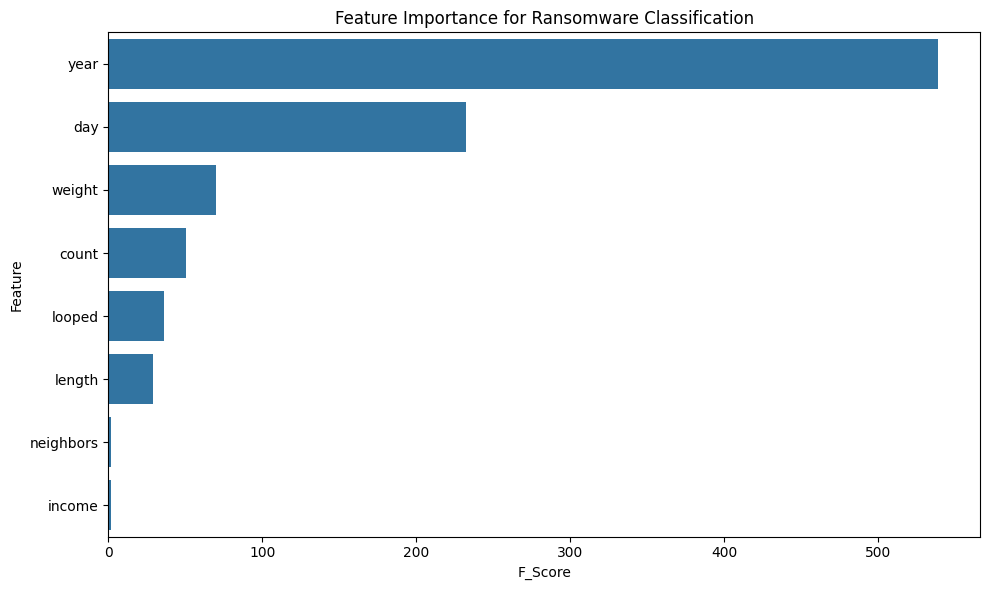

In [ ]:
#rank features by their ability to distinguish between ransomware families
#to know which transaction characteristics are most useful for classifying ransomware types
numerical_features = ['length', 'weight', 'count', 'looped', 'neighbors', 'income', 'year', 'day']

X = df[numerical_features]
y = df['label']

# Use ANOVA F-value for feature selection
selector = SelectKBest(f_classif, k='all')
selector.fit(X, y)

feature_scores = pd.DataFrame({
    'Feature': numerical_features,
    'F_Score': selector.scores_,
    'P_Value': selector.pvalues_
})
feature_scores = feature_scores.sort_values('F_Score', ascending=False)

print("\n=== Feature Importance (ANOVA F-test) ===")
print(feature_scores)


# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='F_Score', y='Feature', data=feature_scores)
plt.title('Feature Importance for Ransomware Classification')
plt.tight_layout()
plt.show()

#from the data info page

 features are designed to quantify specific transaction patterns :

 - Loop is intended to count how many transaction
 1. split their coins
 2. move these coins in the network by using different paths and finally
 3. merge them in a single address.

 Coins at this final address can then be sold and converted to fiat currency.

 - Weight quantifies the merge behavior (i.e., the transaction has more input addresses than output addresses), where coins in multiple addresses are each passed through a succession of merging transactions and accumulated in a final address

# preprocessing

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler


#combine samples of classes with less than a hundred samples and keeping class white and random forest training

In [ ]:
# Determine which classes are rare (fewer than 100 samples)
class_counts = y.value_counts()
rare_classes = class_counts[class_counts < 100].index

print(f"Combining {len(rare_classes)} rare classes (<100 samples) into 'other'")

# Replace rare classes in the target
y_modified = y.copy()
y_modified[y_modified.isin(rare_classes)] = 'other'

# Recalculate X and y
X = df[numerical_features]
y = y_modified


# Split the data
# Initial split: Train+Val vs Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Secondary split: Train vs Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

#  Define pipeline with oversampling and model randomforest
model = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

#  Train on train set
model.fit(X_train_scaled, y_train_encoded)




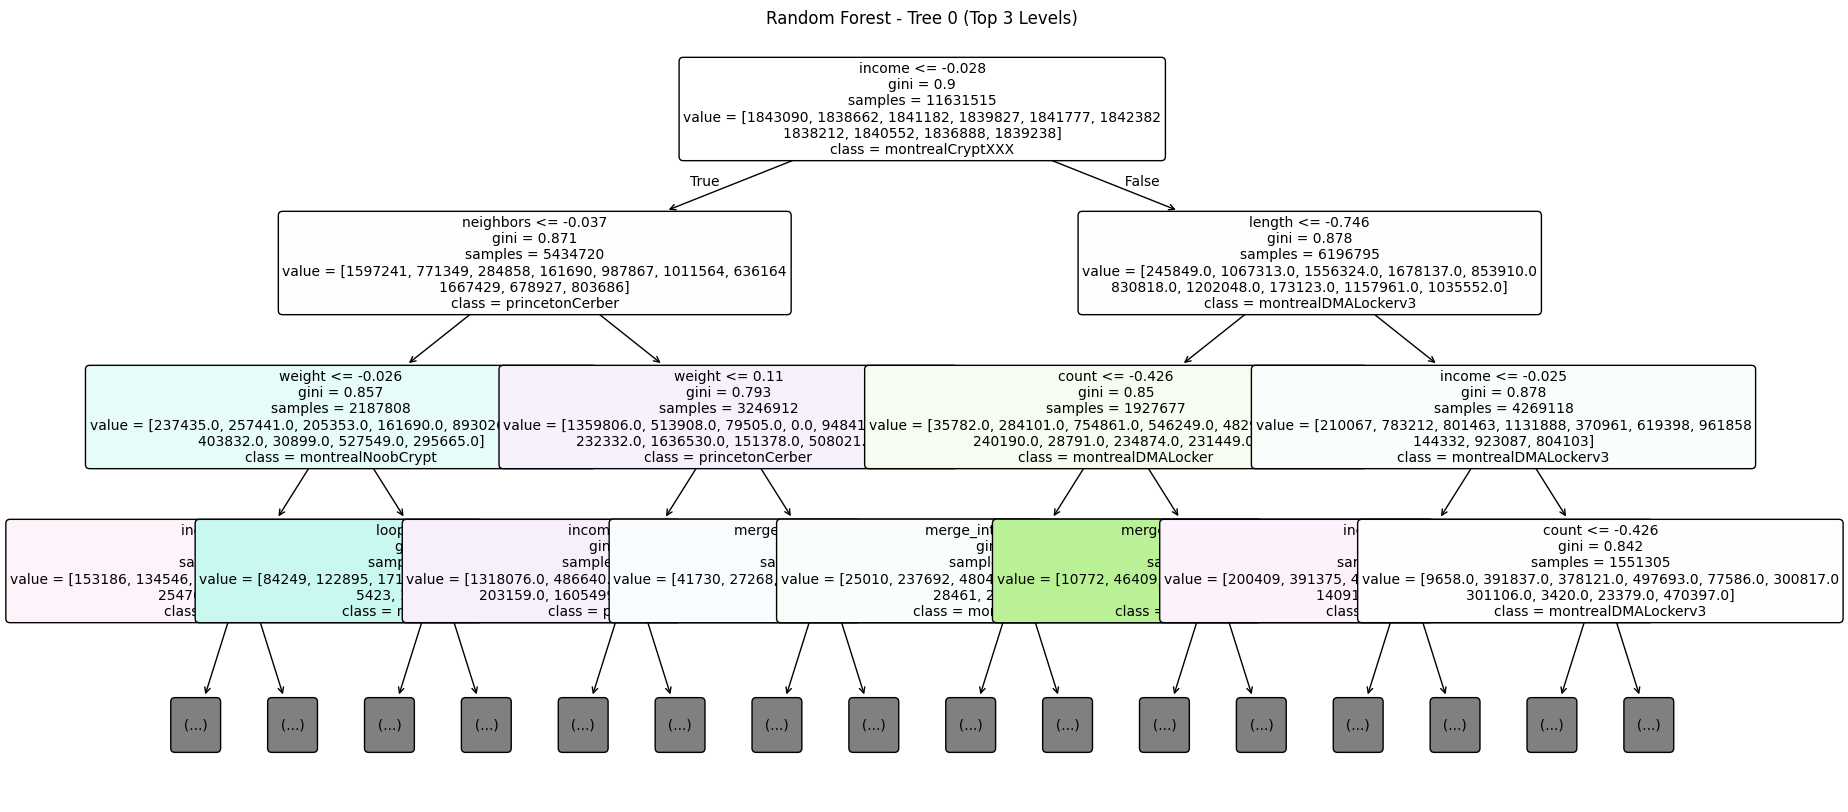

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Extract the trained RandomForestClassifier from the pipeline
rf_model = model.named_steps['classifier']

# Select one of the individual decision trees
single_tree = rf_model.estimators_[0]

# Plot the selected tree
plt.figure(figsize=(20, 10))
plot_tree(
    single_tree,
    feature_names=features,
    class_names=label_encoder.classes_,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10
)
plt.title("Random Forest - Tree 0 (Top 3 Levels)")
plt.show()



In [ ]:
# === Evaluate on validation set ===
y_val_pred = model.predict(X_val_scaled)

print("\n=== decision tree - Validation Results ===")
print("Accuracy:", accuracy_score(y_val_encoded, y_val_pred))
print("F1 Score:", f1_score(y_val_encoded, y_val_pred, average='weighted'))
print("Precision:", precision_score(y_val_encoded, y_val_pred, average='weighted'))
print("Recall:", recall_score(y_val_encoded, y_val_pred, average='weighted'))
# Predicting for the training set
y_train_pred = model.predict(X_train_scaled)

# Print the results for the training set
print("\n=== descision tree - Training Results ===")
print("Accuracy (Training):", accuracy_score(y_train_encoded, y_train_pred))
print("F1 Score (weighted - Training):", f1_score(y_train_encoded, y_train_pred, average='weighted'))
print("Precision (weighted - Training):", precision_score(y_train_encoded, y_train_pred, average='weighted'))
print("Recall (weighted - Training):", recall_score(y_train_encoded, y_train_pred, average='weighted'))


=== decision tree - Validation Results ===
Accuracy: 0.9301993691500668
F1 Score: 0.9517725263752954
Precision: 0.9758304162599153
Recall: 0.9301993691500668

=== descision tree - Training Results ===
Accuracy (Training): 0.9452328593201317
F1 Score (weighted - Training): 0.9634432109701624
Precision (weighted - Training): 0.9892769679389575
Recall (weighted - Training): 0.9452328593201317


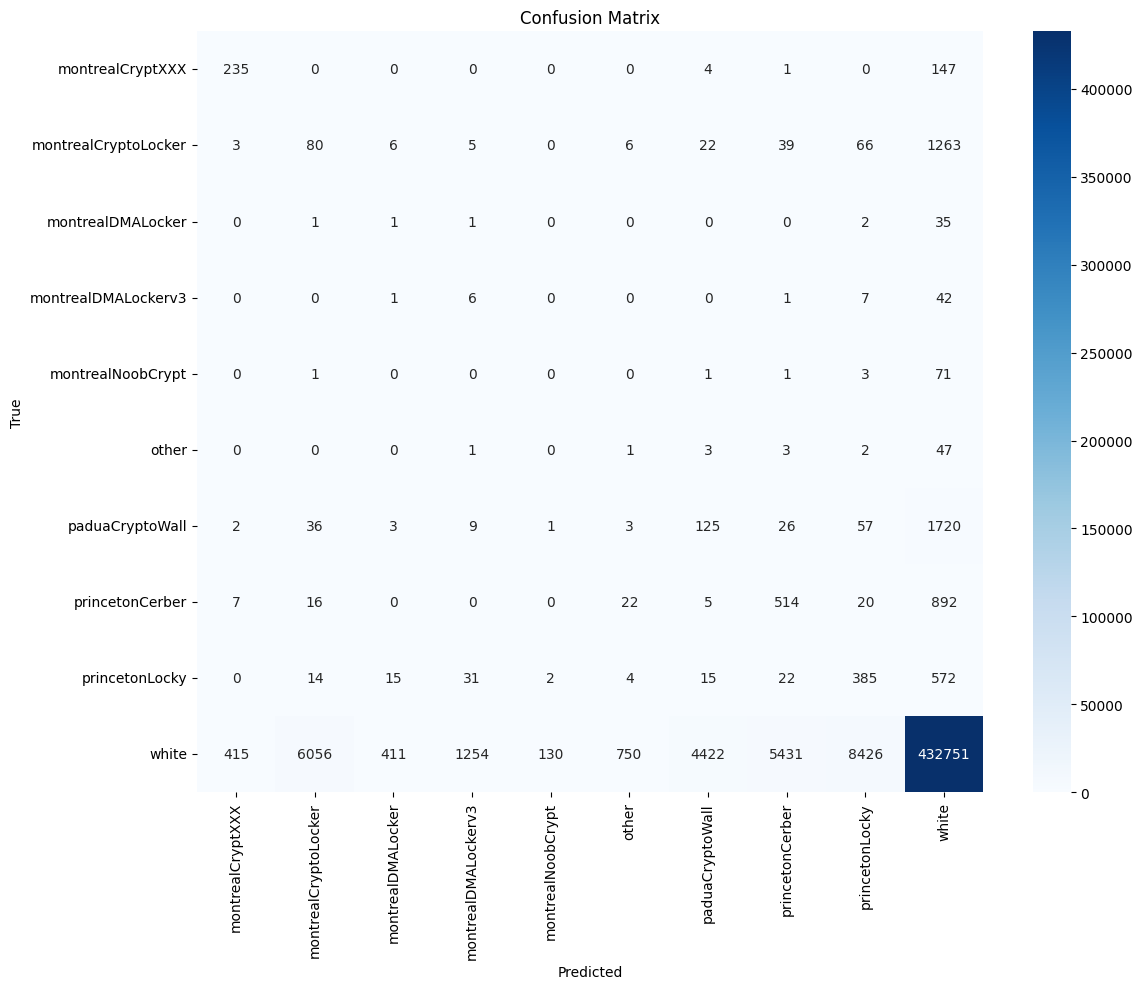


=== Classification Report ===
                      precision    recall  f1-score   support

    montrealCryptXXX       0.35      0.61      0.45       387
montrealCryptoLocker       0.01      0.05      0.02      1490
   montrealDMALocker       0.00      0.03      0.00        40
 montrealDMALockerv3       0.00      0.11      0.01        57
   montrealNoobCrypt       0.00      0.00      0.00        77
               other       0.00      0.02      0.00        57
     paduaCryptoWall       0.03      0.06      0.04      1982
     princetonCerber       0.09      0.35      0.14      1476
      princetonLocky       0.04      0.36      0.08      1060
               white       0.99      0.94      0.96    460046

            accuracy                           0.93    466672
           macro avg       0.15      0.25      0.17    466672
        weighted avg       0.98      0.93      0.95    466672



In [ ]:
# Generate confusion matrix on val
cm = confusion_matrix(y_val_encoded, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\n=== Classification Report ===")
print(classification_report(
    y_val_encoded,
    y_val_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))

the results show horrible performance on classes that arent white

In [ ]:
# === Final Test Set Evaluation  ===
y_test_pred = model.predict(X_test_scaled)
print("\n=== Best Model - Final Test Results ===")
print("Accuracy:", accuracy_score(y_test_encoded, y_test_pred))
print("F1 Score (weighted):", f1_score(y_test_encoded, y_test_pred, average='weighted'))
print("Precision (weighted):", precision_score(y_test_encoded, y_test_pred, average='weighted'))
print("Recall (weighted):", recall_score(y_test_encoded, y_test_pred, average='weighted'))


=== Best Model - Final Test Results ===
Accuracy: 0.9302705111941578
F1 Score (weighted): 0.9518647961181054
Precision (weighted): 0.976005723759225
Recall (weighted): 0.9302705111941578


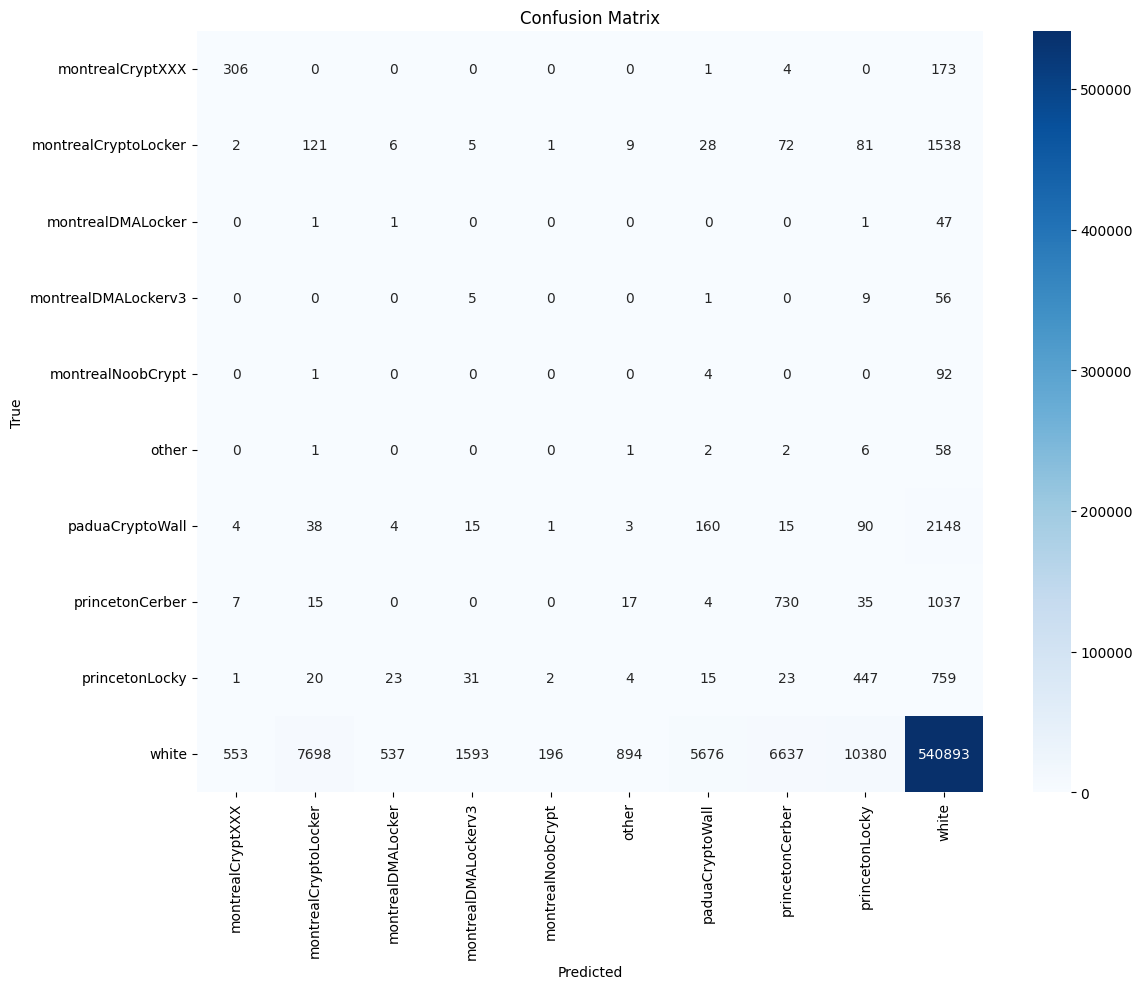


=== Classification Report ===
                      precision    recall  f1-score   support

    montrealCryptXXX       0.35      0.61      0.45       387
montrealCryptoLocker       0.01      0.05      0.02      1490
   montrealDMALocker       0.00      0.03      0.00        40
 montrealDMALockerv3       0.00      0.11      0.01        57
   montrealNoobCrypt       0.00      0.00      0.00        77
               other       0.00      0.02      0.00        57
     paduaCryptoWall       0.03      0.06      0.04      1982
     princetonCerber       0.09      0.35      0.14      1476
      princetonLocky       0.04      0.36      0.08      1060
               white       0.99      0.94      0.96    460046

            accuracy                           0.93    466672
           macro avg       0.15      0.25      0.17    466672
        weighted avg       0.98      0.93      0.95    466672



In [ ]:
# Generate confusion matrix on test
cm = confusion_matrix(y_test_encoded, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\n=== Classification Report ===")
print(classification_report(
    y_val_encoded,
    y_val_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))

#The final preprocessing used :dropping classes with less than 100 samples and white due to huge imbalance and and it bieng not relevant to our task since it represents benign classes






In [ ]:
# Feature preprocessing

# Create derived features based on data info

df['merge_intensity'] = df['weight'] * df['count']
df['loop_complexity'] = df['looped'] * df['length']



# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Drop 'white' and rare classes (<100 samples)
min_samples = 100
class_counts = y.value_counts()

# Get classes to keep
valid_classes = class_counts[(class_counts >= min_samples) & (class_counts.index != 'white')].index

# Filter the dataframe
df_filtered = df[df['label'].isin(valid_classes)]

# Redefine X and y after filtering
X = df_filtered[numerical_features + ['merge_intensity', 'loop_complexity','year','day']]
y = df_filtered['label']

# Split the data
# Initial split: Train+Val vs Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Secondary split: Train vs Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)




# random forest


In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

#  Define pipeline with oversampling and model
model = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),  # Oversampler to balance classes
    ('classifier', RandomForestClassifier(random_state=42))  # Random Forest Classifier
])

# Define the search space
param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

# Perform random search with 3 folds and 10 iterations
random_search = RandomizedSearchCV(model, param_distributions, n_iter=10, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Train the model
random_search.fit(X_train_scaled, y_train_encoded)

# Best parameters from random search
print(f"Best parameters found by RandomizedSearchCV: {random_search.best_params_}")

# Get the best model from the random search
best_model = random_search.best_estimator_

# === Evaluate on validation set ===
y_val_pred = best_model.predict(X_val_scaled)

print("\n=== Random Forest - Validation Results ===")
print("Accuracy:", accuracy_score(y_val_encoded, y_val_pred))
print("F1 Score:", f1_score(y_val_encoded, y_val_pred, average='weighted'))
print("Precision:", precision_score(y_val_encoded, y_val_pred, average='weighted'))
print("Recall:", recall_score(y_val_encoded, y_val_pred, average='weighted'))





Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt, **la

Best parameters found by RandomizedSearchCV: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 20}

=== Random Forest - Validation Results ===
Accuracy: 0.965296803652968
F1 Score: 0.9641103576104607
Precision: 0.9639293216812282
Recall: 0.965296803652968


In [ ]:
# Predicting for the training set
y_train_pred = best_model.predict(X_train_scaled)

# Print the results for the training set
print("\n=== Random Forest - Training Results ===")
print("Accuracy (Training):", accuracy_score(y_train_encoded, y_train_pred))
print("F1 Score (weighted - Training):", f1_score(y_train_encoded, y_train_pred, average='weighted'))
print("Precision (weighted - Training):", precision_score(y_train_encoded, y_train_pred, average='weighted'))
print("Recall (weighted - Training):", recall_score(y_train_encoded, y_train_pred, average='weighted'))


=== Random Forest - Training Results ===
Accuracy (Training): 0.9935687647461755
F1 Score (weighted - Training): 0.9935644024139322
Precision (weighted - Training): 0.9936212667699963
Recall (weighted - Training): 0.9935687647461755


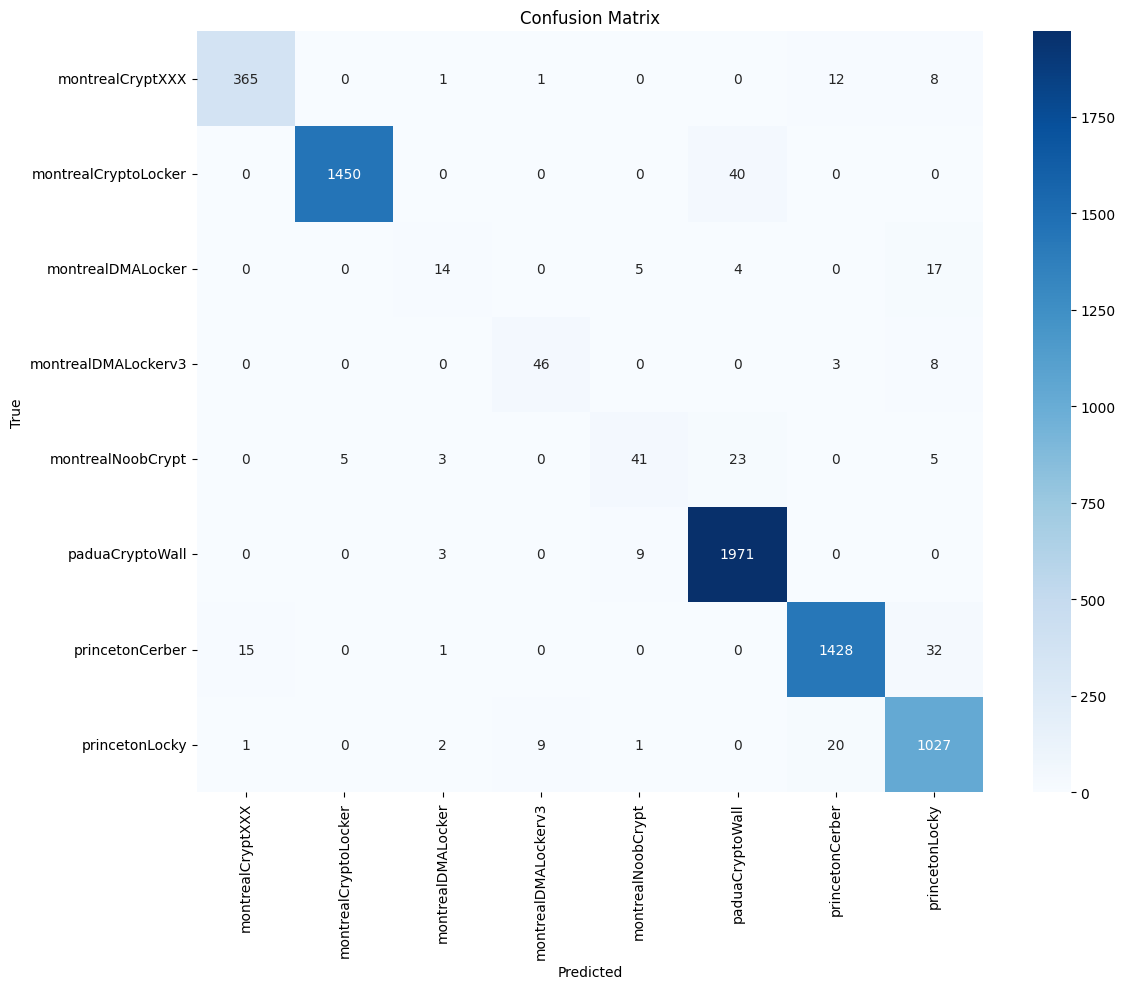


=== Classification Report ===
                      precision    recall  f1-score   support

    montrealCryptXXX       0.96      0.94      0.95       387
montrealCryptoLocker       1.00      0.97      0.98      1490
   montrealDMALocker       0.58      0.35      0.44        40
 montrealDMALockerv3       0.82      0.81      0.81        57
   montrealNoobCrypt       0.73      0.53      0.62        77
     paduaCryptoWall       0.97      0.99      0.98      1983
     princetonCerber       0.98      0.97      0.97      1476
      princetonLocky       0.94      0.97      0.95      1060

            accuracy                           0.97      6570
           macro avg       0.87      0.82      0.84      6570
        weighted avg       0.96      0.97      0.96      6570



In [ ]:
# Generate confusion matrix on val
cm = confusion_matrix(y_val_encoded, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\n=== Classification Report ===")
print(classification_report(
    y_val_encoded,
    y_val_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))

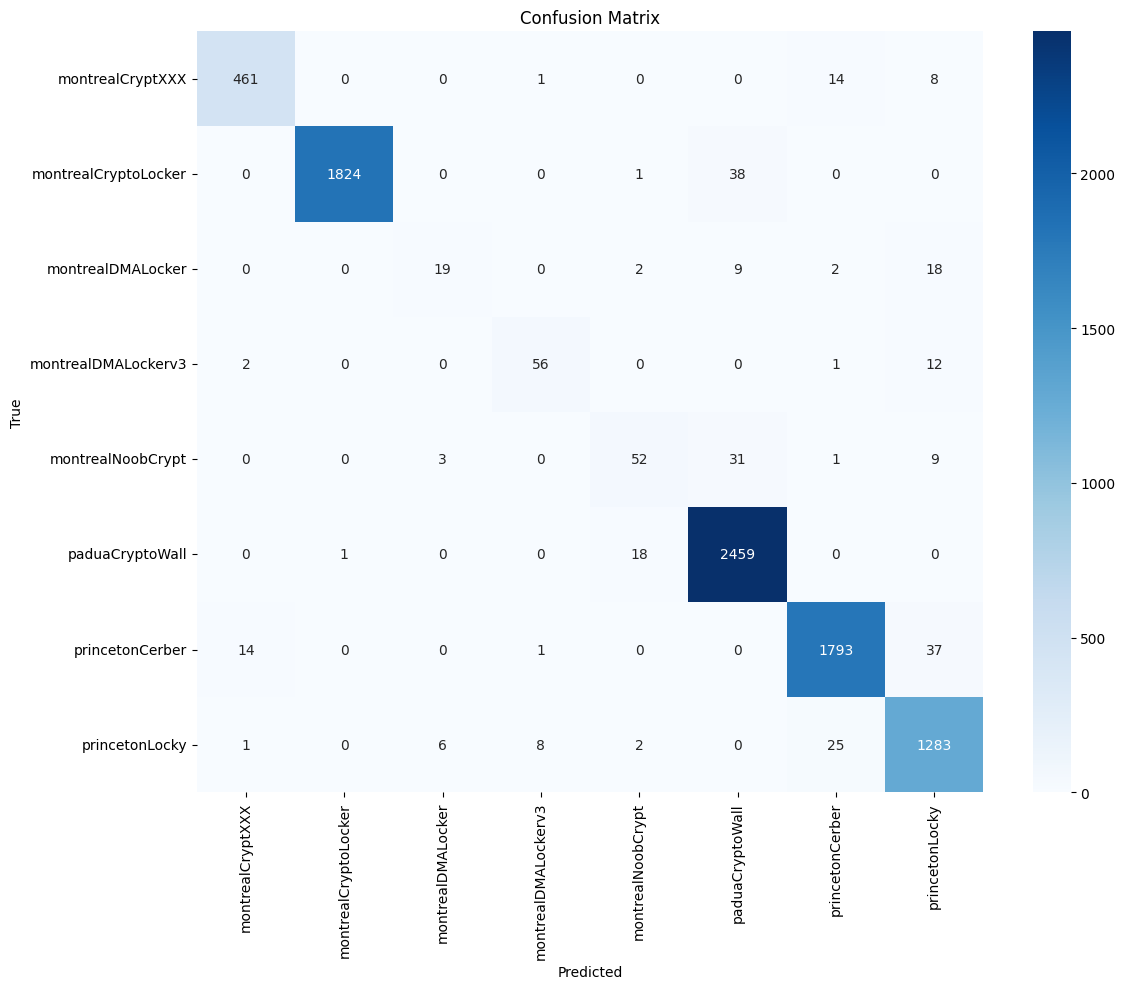


=== Classification Report ===
                      precision    recall  f1-score   support

    montrealCryptXXX       0.96      0.95      0.96       484
montrealCryptoLocker       1.00      0.98      0.99      1863
   montrealDMALocker       0.68      0.38      0.49        50
 montrealDMALockerv3       0.85      0.79      0.82        71
   montrealNoobCrypt       0.69      0.54      0.61        96
     paduaCryptoWall       0.97      0.99      0.98      2478
     princetonCerber       0.98      0.97      0.97      1845
      princetonLocky       0.94      0.97      0.95      1325

            accuracy                           0.97      8212
           macro avg       0.88      0.82      0.85      8212
        weighted avg       0.97      0.97      0.97      8212



In [ ]:

y_test_pred = best_model.predict(X_test_scaled)
# Generate confusion matrix on test
cm = confusion_matrix(y_test_encoded, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\n=== Classification Report ===")
print(classification_report(
    y_test_encoded,
    y_test_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))

#svm

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler

#  Define pipeline with oversampling and SVM
svm_model = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', SVC(kernel='linear', random_state=42))
])

# Train on training set
svm_model.fit(X_train_scaled, y_train_encoded)

#  Evaluate on validation set
y_val_pred = svm_model.predict(X_val_scaled)

print("\n=== SVM - Validation Results ===")
print("Accuracy:", accuracy_score(y_val_encoded, y_val_pred))
print("F1 Score (weighted):", f1_score(y_val_encoded, y_val_pred, average='weighted'))
print("Precision (weighted):", precision_score(y_val_encoded, y_val_pred, average='weighted'))
print("Recall (weighted):", recall_score(y_val_encoded, y_val_pred, average='weighted'))

# Evaluate on training set
y_train_pred = svm_model.predict(X_train_scaled)

print("\n=== SVM - Training Results ===")
print("Accuracy (Training):", accuracy_score(y_train_encoded, y_train_pred))
print("F1 Score (weighted - Training):", f1_score(y_train_encoded, y_train_pred, average='weighted'))
print("Precision (weighted - Training):", precision_score(y_train_encoded, y_train_pred, average='weighted'))
print("Recall (weighted - Training):", recall_score(y_train_encoded, y_train_pred, average='weighted'))




=== SVM - Validation Results ===
Accuracy: 0.7715372907153729
F1 Score (weighted): 0.8124867770829289
Precision (weighted): 0.8932611094978639
Recall (weighted): 0.7715372907153729

=== SVM - Training Results ===
Accuracy (Training): 0.7714437932871604
F1 Score (weighted - Training): 0.8136615679205568
Precision (weighted - Training): 0.8947126661233923
Recall (weighted - Training): 0.7714437932871604


#svm with rbf

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler

#  Define pipeline with oversampling and SVM
svm_model_rbf = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', SVC(kernel='rbf', random_state=42))
])

#  Train on training set
svm_model_rbf.fit(X_train_scaled, y_train_encoded)

#  Evaluate on validation set
y_val_pred = svm_model_rbf.predict(X_val_scaled)

print("\n=== SVM - Validation Results ===")
print("Accuracy:", accuracy_score(y_val_encoded, y_val_pred))
print("F1 Score (weighted):", f1_score(y_val_encoded, y_val_pred, average='weighted'))
print("Precision (weighted):", precision_score(y_val_encoded, y_val_pred, average='weighted'))
print("Recall (weighted):", recall_score(y_val_encoded, y_val_pred, average='weighted'))

#  Evaluate on training set
y_train_pred = svm_model_rbf.predict(X_train_scaled)

print("\n=== SVM - Training Results ===")
print("Accuracy (Training):", accuracy_score(y_train_encoded, y_train_pred))
print("F1 Score (weighted - Training):", f1_score(y_train_encoded, y_train_pred, average='weighted'))
print("Precision (weighted - Training):", precision_score(y_train_encoded, y_train_pred, average='weighted'))
print("Recall (weighted - Training):", recall_score(y_train_encoded, y_train_pred, average='weighted'))




=== SVM - Validation Results ===
Accuracy: 0.8321156773211568
F1 Score (weighted): 0.8513462664637879
Precision (weighted): 0.8961353445983786
Recall (weighted): 0.8321156773211568

=== SVM - Training Results ===
Accuracy (Training): 0.8347286703706522
F1 Score (weighted - Training): 0.854980721951575
Precision (weighted - Training): 0.9008565238136951
Recall (weighted - Training): 0.8347286703706522


# DNN

In [ ]:
pip install tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

#  One-hot encode labels
num_classes = len(np.unique(y_train_encoded))
y_train_cat = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes=num_classes)

#  Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))

#  Define the DNN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optim                                                                                                             izer='adam',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=30,
    batch_size=32,
    class_weight=class_weights_dict,
    verbose=2
)

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val_scaled, y_val_cat)
print(f"\nValidation Accuracy: {val_acc:.4f}")

#  Predict and report performance
y_val_pred_probs = model.predict(X_val_scaled)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

from sklearn.metrics import classification_report
print("\nClassification Report (Validation):")
print(classification_report(y_val_encoded, y_val_pred, target_names=label_encoder.classes_))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
822/822 - 10s - 12ms/step - accuracy: 0.5776 - loss: 1.4215 - val_accuracy: 0.7268 - val_loss: 0.8032
Epoch 2/30
822/822 - 6s - 7ms/step - accuracy: 0.6781 - loss: 1.0413 - val_accuracy: 0.7408 - val_loss: 0.6900
Epoch 3/30
822/822 - 2s - 3ms/step - accuracy: 0.7202 - loss: 0.9049 - val_accuracy: 0.7822 - val_loss: 0.6203
Epoch 4/30
822/822 - 2s - 3ms/step - accuracy: 0.7481 - loss: 0.8449 - val_accuracy: 0.8094 - val_loss: 0.5532
Epoch 5/30
822/822 - 2s - 3ms/step - accuracy: 0.7574 - loss: 0.8102 - val_accuracy: 0.8139 - val_loss: 0.5244
Epoch 6/30
822/822 - 3s - 3ms/step - accuracy: 0.7778 - loss: 0.7802 - val_accuracy: 0.8099 - val_loss: 0.5174
Epoch 7/30
822/822 - 3s - 3ms/step - accuracy: 0.7823 - loss: 0.7498 - val_accuracy: 0.8011 - val_loss: 0.5782
Epoch 8/30
822/822 - 5s - 6ms/step - accuracy: 0.7822 - loss: 0.7329 - val_accuracy: 0.8183 - val_loss: 0.4865
Epoch 9/30
822/822 - 2s - 3ms/step - accuracy: 0.7884 - loss: 0.7057 - val_accuracy: 0.8245 - val_loss: 0.4861

In [ ]:
pip install tensorflow-addons


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

#  One-hot encode labels
num_classes = len(np.unique(y_train_encoded))
y_train_cat = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_cat = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_cat = to_categorical(y_test_encoded, num_classes=num_classes)

#  Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))

#  Define the DNN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_val_scaled, y_val_cat),
    epochs=30,
    batch_size=32,
    class_weight=class_weights_dict,
    verbose=2
)

# Evaluate the model
val_loss, val_acc = model.evaluate(X_val_scaled, y_val_cat)
print(f"\nValidation Accuracy: {val_acc:.4f}")

#  Predict and report performance
y_val_pred_probs = model.predict(X_val_scaled)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

from sklearn.metrics import classification_report
print("\nClassification Report (Validation):")
print(classification_report(y_val_encoded, y_val_pred, target_names=label_encoder.classes_))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
822/822 - 7s - 9ms/step - accuracy: 0.3477 - loss: 1.8081 - val_accuracy: 0.5970 - val_loss: 1.2705
Epoch 2/30
822/822 - 7s - 8ms/step - accuracy: 0.5261 - loss: 1.3922 - val_accuracy: 0.6851 - val_loss: 0.9892
Epoch 3/30
822/822 - 2s - 3ms/step - accuracy: 0.5865 - loss: 1.2212 - val_accuracy: 0.7356 - val_loss: 0.8377
Epoch 4/30
822/822 - 2s - 3ms/step - accuracy: 0.6341 - loss: 1.1061 - val_accuracy: 0.7467 - val_loss: 0.7689
Epoch 5/30
822/822 - 3s - 3ms/step - accuracy: 0.6576 - loss: 1.0477 - val_accuracy: 0.7466 - val_loss: 0.7150
Epoch 6/30
822/822 - 3s - 3ms/step - accuracy: 0.6823 - loss: 0.9813 - val_accuracy: 0.7556 - val_loss: 0.6920
Epoch 7/30
822/822 - 3s - 3ms/step - accuracy: 0.6966 - loss: 0.9423 - val_accuracy: 0.7767 - val_loss: 0.6341
Epoch 8/30
822/822 - 2s - 3ms/step - accuracy: 0.7166 - loss: 0.9189 - val_accuracy: 0.7521 - val_loss: 0.6937
Epoch 9/30
822/822 - 2s - 3ms/step - accuracy: 0.7211 - loss: 0.8777 - val_accuracy: 0.7855 - val_loss: 0.6249
E

# Lightgbm

In [ ]:
pip install lightgbm


In [ ]:
from imblearn.pipeline import Pipeline  # Importing Pipeline from imblearn
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier  # Importing LightGBM Classifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


# Define pipeline with oversampling and LightGBM
model = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),  # Oversampler to balance classes
    ('classifier', LGBMClassifier(random_state=42))  # LightGBM Classifier
])

# Define the search space for hyperparameter tuning
param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [10, 20, -1],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__num_leaves': [31, 50, 100],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Perform random search with 3 folds and 10 iterations
random_search = RandomizedSearchCV(model, param_distributions, n_iter=10, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Train the model
random_search.fit(X_train_scaled, y_train_encoded)

# Best parameters from random search
print(f"Best parameters found by RandomizedSearchCV: {random_search.best_params_}")

# Get the best model from the random search
best_model_gbm = random_search.best_estimator_

# === Evaluate on validation set ===z
y_val_pred = best_model_gbm.predict(X_val_scaled)

print("\n=== LightGBM - Validation Results ===")
print("Accuracy:", accuracy_score(y_val_encoded, y_val_pred))
print("F1 Score (weighted):", f1_score(y_val_encoded, y_val_pred, average='weighted'))
print("Precision (weighted):", precision_score(y_val_encoded, y_val_pred, average='weighted'))
print("Recall (weighted):", recall_score(y_val_encoded, y_val_pred, average='weighted'))

# Predicting for the training set
y_train_pred = best_model_gbm.predict(X_train_scaled)

# Print the results for the training set
print("\n=== LightGBM - Training Results ===")
print("Accuracy (Training):", accuracy_score(y_train_encoded, y_train_pred))
print("F1 Score (weighted - Training):", f1_score(y_train_encoded, y_train_pred, average='weighted'))
print("Precision (weighted - Training):", precision_score(y_train_encoded, y_train_pred, average='weighted'))
print("Recall (weighted - Training):", recall_score(y_train_encoded, y_train_pred, average='weighted'))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 63432, number of used features: 10
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== LightGBM - Validation Results ===
Accuracy: 0.971689497716895
F1 Score (weighted): 0.9708637408855384
Precision (weighted): 0.9707272691081936
Recall (weighted): 0.971689497716895


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== LightGBM - Training Results ===
Accuracy (Training): 0.9997336174746937
F1 Score (weighted - Training): 0.999733720124561
Precision (weighted - Training): 0.9997341284426644
Recall (weighted - Training): 0.9997336174746937


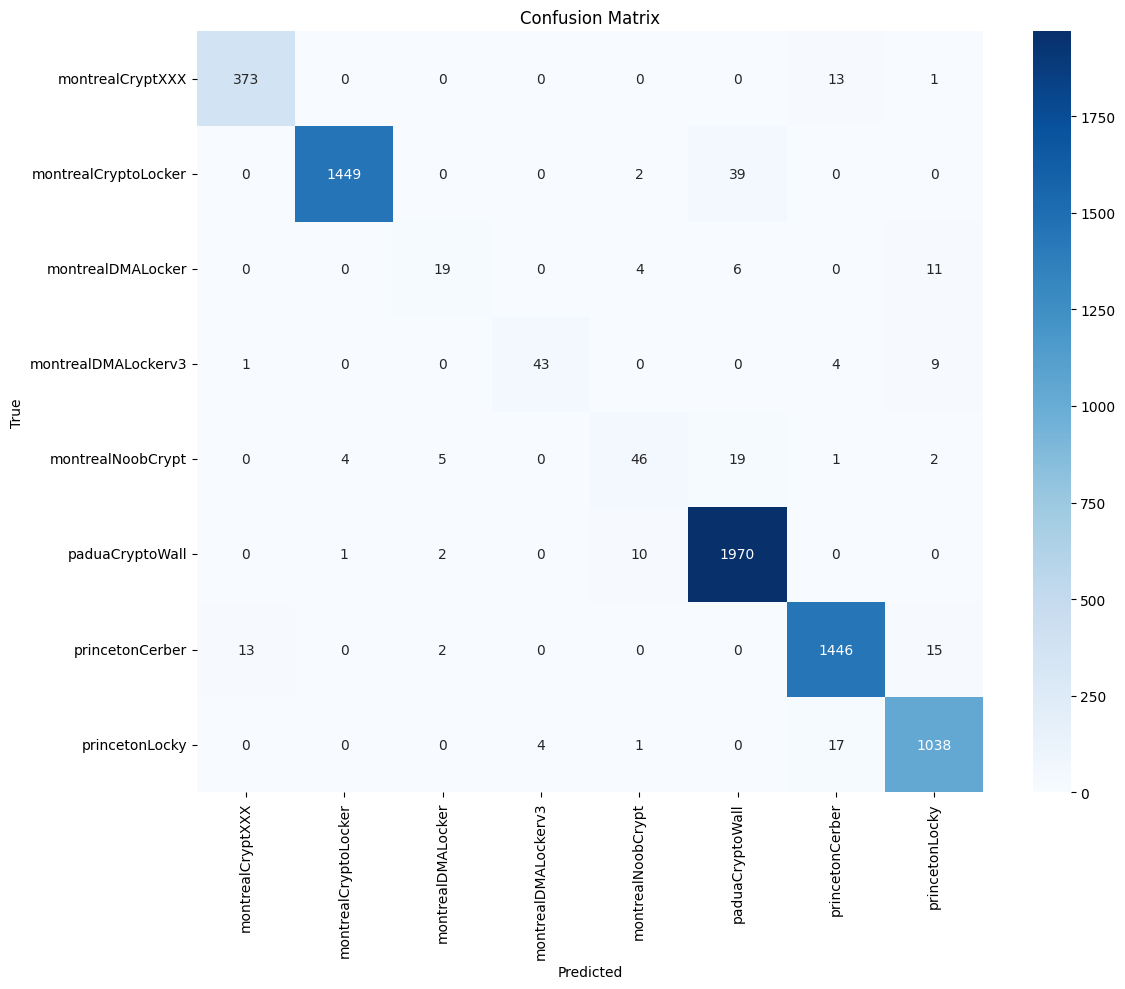


=== Classification Report ===
                      precision    recall  f1-score   support

    montrealCryptXXX       0.96      0.96      0.96       387
montrealCryptoLocker       1.00      0.97      0.98      1490
   montrealDMALocker       0.68      0.47      0.56        40
 montrealDMALockerv3       0.91      0.75      0.83        57
   montrealNoobCrypt       0.73      0.60      0.66        77
     paduaCryptoWall       0.97      0.99      0.98      1983
     princetonCerber       0.98      0.98      0.98      1476
      princetonLocky       0.96      0.98      0.97      1060

            accuracy                           0.97      6570
           macro avg       0.90      0.84      0.87      6570
        weighted avg       0.97      0.97      0.97      6570



In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_val_encoded, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\n=== Classification Report ===")
print(classification_report(
    y_val_encoded,
    y_val_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


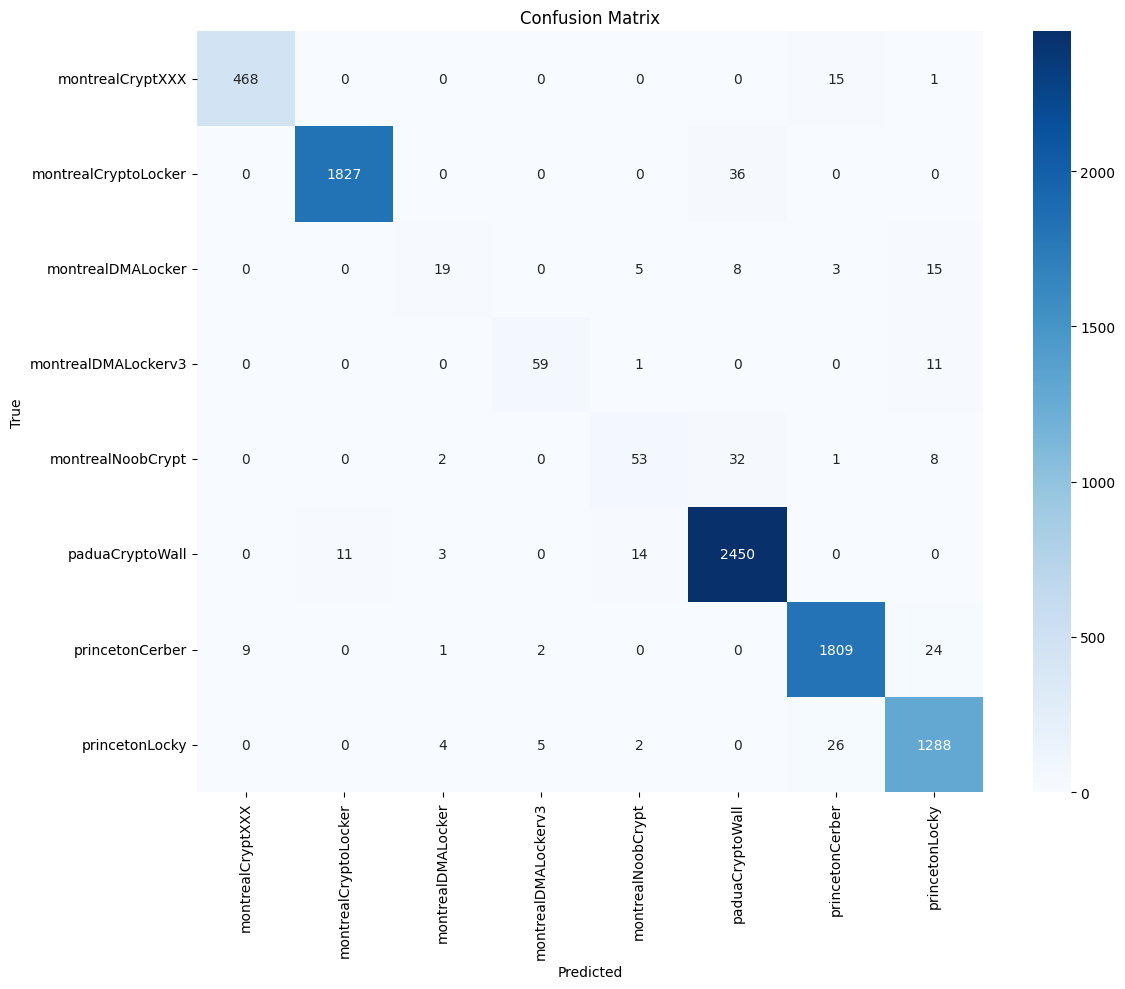


=== Classification Report ===
                      precision    recall  f1-score   support

    montrealCryptXXX       0.98      0.97      0.97       484
montrealCryptoLocker       0.99      0.98      0.99      1863
   montrealDMALocker       0.66      0.38      0.48        50
 montrealDMALockerv3       0.89      0.83      0.86        71
   montrealNoobCrypt       0.71      0.55      0.62        96
     paduaCryptoWall       0.97      0.99      0.98      2478
     princetonCerber       0.98      0.98      0.98      1845
      princetonLocky       0.96      0.97      0.96      1325

            accuracy                           0.97      8212
           macro avg       0.89      0.83      0.86      8212
        weighted avg       0.97      0.97      0.97      8212



In [ ]:
# === Evaluate on test set ===
y_test_pred = best_model_gbm.predict(X_test_scaled)
# Generate confusion matrix
cm = confusion_matrix(y_test_encoded, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\n=== Classification Report ===")
print(classification_report(
    y_test_encoded,
    y_test_pred,
    target_names=label_encoder.classes_,
    zero_division=0
))